In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# read data into memory
data_set = np.genfromtxt("/Users/ozlemserifogullari/Documents/ENGR421/HW5/hw05_data_set_train.csv", delimiter = ",", skip_header = 0)

# get x and y values
x_train = data_set[:,0]
y_train = data_set[:,1]

# get number of samples
N = data_set.shape[0]


In [3]:
test_set = np.genfromtxt("/Users/ozlemserifogullari/Documents/ENGR421/HW5/hw05_data_set_test.csv", delimiter = ",", skip_header = 0)

# get x and y values
x_test = test_set[:,0]
y_test = test_set[:,1]

# get number of test case
N_test = test_set.shape[0]


In [15]:
def dt_create(x, y, P, no):
    # create necessary data structures
    node_indices = {}
    is_terminal = {}
    need_split = {}
    node_splits = {}

    # put all training instances into the root node
    node_indices[1] = np.array(range(no))
    is_terminal[1] = False
    need_split[1] = True
    
    while True:
        # find nodes that need splitting
        split_nodes = [key for key, value in need_split.items()
                   if value == True]
        
        # check whether we reach all terminal nodes
        if len(split_nodes) == 0:
            break
        
        # prune the three with P
        for split_node in split_nodes:
            data_indices = node_indices[split_node]
            need_split[split_node] = False
            
            # if P is reached terminate
            if(data_indices.size <= P):
                node_splits[split_node] = np.mean(y[data_indices])
                is_terminal[split_node] = True
    
            # otherwise continue to prune
            else:
                is_terminal[split_node] = False
                unique_values = np.sort(np.unique(x[data_indices]))
                split_positions = (unique_values[1:len(unique_values)] + unique_values[0:(len(unique_values) - 1)]) / 2
                split_scores = np.repeat(0.0, len(split_positions))
                
                for s in range(len(split_positions)):
                    left_indices = data_indices[x[data_indices] >  split_positions[s]]
                    right_indices = data_indices[x[data_indices] <=  split_positions[s]]
                    split_scores[s] = np.sum((y[left_indices] - np.mean(y[left_indices])) ** 2) + np.sum((y[right_indices] - np.mean(y[right_indices])) ** 2)
                    split_scores[s] /= (left_indices.size + right_indices.size)
                    
                best_split = split_positions[np.argmin(split_scores)]
                node_splits[split_node] = best_split

                
                left_indices = data_indices[x[data_indices] > best_split]
                right_indices = data_indices[x[data_indices] <= best_split]
                
                node_indices[2 * split_node] = left_indices
                is_terminal[2 * split_node] = False
                need_split[2 * split_node] = True
                
                node_indices[2 * split_node + 1] = right_indices
                is_terminal[2 * split_node + 1] = False
                need_split[2 * split_node + 1] = True
                
    return is_terminal, node_splits

def dt_reg(x, is_terminal, no, node_splits):
    result = np.zeros(no)
    for i in range(no):
        index = 1
        while True:
            if is_terminal[index] == True:
                result[i] = node_splits[index]
                break
            else:
                if x[i] > node_splits[index]:
                    index = index * 2
                else:
                    index = index * 2 + 1
    return result

def plot_dt(interval, result):
    plt.figure(figsize = (10, 4))
    plt.xlabel("Time(sec)")
    plt.ylabel("Signal(millivolt)")
    
    plt.plot(x_train, y_train, "b.", markersize = 10, label = "training")
    plt.legend(loc = "upper right")
    plt.plot(interval, result, "k")
    
    plt.figure(figsize = (10, 4))
    plt.xlabel("Time(sec)")
    plt.ylabel("Signal(millivolt)")
    
    plt.plot(x_test, y_test, "r.", markersize = 10, label = "test")
    plt.legend(loc = "upper right")
    plt.plot(interval, result, "k")
    
def RMSE(y_truth, y_pred):
    return np.sqrt(np.mean((y_truth - y_pred)**2))
    
    
    

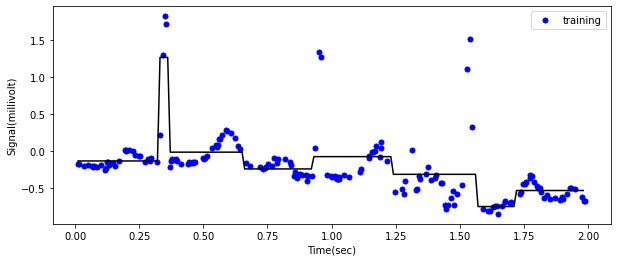

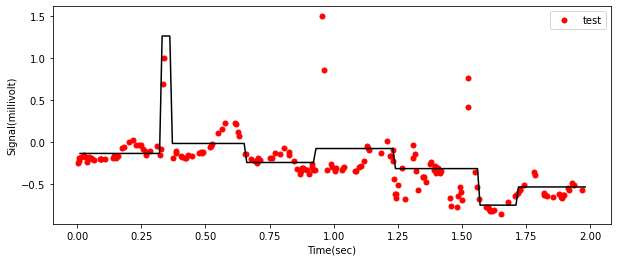

In [16]:
terminal_info, ns = dt_create(x_train, y_train, 30, N)
data_interval = np.arange(min(x_train), max(x_train),0.01)
reg_result = dt_reg(data_interval, terminal_info, len(data_interval), ns)
plot_dt(data_interval, reg_result)


In [11]:
reg_result_train = dt_reg(x_train, terminal_info, N, ns)
print("RMSE on training set is ", RMSE(y_train, reg_result_train), " when P is 30")
reg_result_test = dt_reg(x_test, terminal_info, N_test, ns)
print("RMSE on test set is ", RMSE(y_test, reg_result_test), " when P is 30")


RMSE on training set is  0.2881929342801884  when P is 30
RMSE on test set is  0.22542236010134897  when P is 30


In [12]:
# Learn decision trees by changing the pre-pruning parameter p
p_values = np.arange(10,55,5)
rmse_train = []
rmse_test = []

for p in p_values:
    ti, ns = dt_create(x_train, y_train, p, N)
    y_pred_train = dt_reg(x_train, ti, N, ns)
    rmse = RMSE(y_train, y_pred_train)
    rmse_train.append(rmse)
    y_pred_test = dt_reg(x_test, ti, N_test, ns)
    rmse = RMSE(y_test, y_pred_test)
    rmse_test.append(rmse)
    

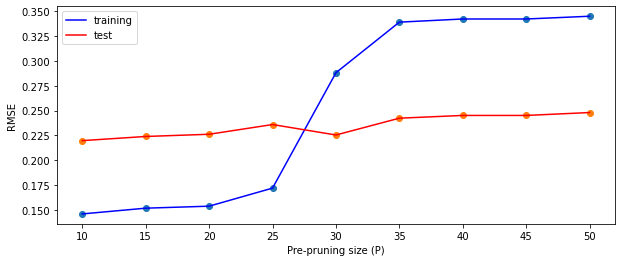

In [8]:
# Draw RMSE for training and test data points as a function of P
f = plt.figure(figsize = (10, 4))
plt.xlabel("Pre-pruning size (P)")
plt.ylabel("RMSE")
plt.scatter(p_values, rmse_train)
plt.plot(p_values, rmse_train,label = "training", color = "blue")
plt.scatter(p_values, rmse_test)
plt.plot(p_values, rmse_test,label = "test", color = "red")
plt.legend(loc = "upper left")
plt.show()   